In [613]:
!pip install pandas scikit-learn seaborn imblearn optuna xgboost boruta tensorflow catboost 

You should consider upgrading via the 'c:\users\user\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


### 1. Get Data

In [614]:
import pandas as pd

df = pd.read_csv("Human_Resources.csv")
data = df.copy()
""" print(df.head()) """
""" print(df["Over18"].head()) """
data.drop(columns=['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], inplace=True)
print(df['Attrition'].value_counts())

Attrition
No     1233
Yes     237
Name: count, dtype: int64


### 2. Pre Processing

In [615]:

from sklearn.calibration import LabelEncoder

data["Attrition"] = data["Attrition"].map({"Yes": 1, "No": 0})

categorical_cols = data.select_dtypes(include="object").columns
le = LabelEncoder()
for col in categorical_cols:
    data[col] = le.fit_transform(data[col]) 

X = data.drop("Attrition", axis=1)
y = data["Attrition"]

print(X)
print(y)

      Age  BusinessTravel  DailyRate  Department  DistanceFromHome  Education  \
0      41               2       1102           2                 1          2   
1      49               1        279           1                 8          1   
2      37               2       1373           1                 2          2   
3      33               1       1392           1                 3          4   
4      27               2        591           1                 2          1   
...   ...             ...        ...         ...               ...        ...   
1465   36               1        884           1                23          2   
1466   39               2        613           1                 6          1   
1467   27               2        155           1                 4          3   
1468   49               1       1023           2                 2          3   
1469   34               2        628           1                 8          3   

      EducationField  Envir

### 3. Feature Selection

In [616]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

sfm = SelectFromModel(model, threshold="median", prefit=True)

X_values = sfm.transform(X)
selected_columns = X.columns[sfm.get_support()]

print(sfm.get_support())
print(X_values) 



[ True False  True False  True False False False False  True False False
  True  True False  True  True  True  True  True False False  True  True
 False False  True False False  True]
[[  41 1102    1 ...    8    6    5]
 [  49  279    8 ...   10   10    7]
 [  37 1373    2 ...    7    0    0]
 ...
 [  27  155    4 ...    6    6    3]
 [  49 1023    2 ...   17    9    8]
 [  34  628    8 ...    6    4    2]]


c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [617]:
print("Most meaningful features:")
for feature in selected_columns:
    print("- "+feature)

Most meaningful features:
- Age
- DailyRate
- DistanceFromHome
- HourlyRate
- JobRole
- JobSatisfaction
- MonthlyIncome
- MonthlyRate
- NumCompaniesWorked
- OverTime
- PercentSalaryHike
- StockOptionLevel
- TotalWorkingYears
- YearsAtCompany
- YearsWithCurrManager


### 4. Data Sampling

In [618]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_values, y)

print("Before smote:", X_values.shape, y.shape)
print("After smote:", X_resampled.shape, y_resampled.shape)
print(pd.Series(y_resampled).value_counts())

Before smote: (1470, 15) (1470,)
After smote: (2326, 15) (2326,)
Attrition
1    1163
0    1163
Name: count, dtype: int64


c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn

### 5. Train Test Split

In [619]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled[3])

[-0.16807889  0.15263104  1.55626355 -1.08294051  1.06220938 -1.34730746
 -0.30981291 -0.94109101 -1.10815747 -0.6196197   2.31671957 -0.7312723
  0.66691767  1.17295258  1.6714003 ]


### 6. Hyperparameter Tuning

In [620]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

def best_hypermeters(trial):
    n_layers = trial.suggest_int("n_layers", 1, 6)
    units = trial.suggest_int("units", 16, 128)
    dropout_rate = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])

    model = Sequential()
    model.add(Dense(units, input_dim=X_train_scaled.shape[1], activation=activation))
    model.add(Dropout(dropout_rate))

    for _ in range(n_layers - 1):
        model.add(Dense(units, activation=activation))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(X_train_scaled, y_train,
              validation_split=0.2,
              epochs=100,
              batch_size=trial.suggest_categorical("batch_size", [16, 32, 64]),
              callbacks=[early_stop],
              verbose=0)

    y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
    acc = accuracy_score(y_test, y_pred)

    return acc

In [621]:
""" import optuna

study = optuna.create_study(direction="maximize")
study.optimize(best_hypermeters, n_trials=30)
                                
print("Best parameters:")
print(study.best_params)  """

' import optuna\n\nstudy = optuna.create_study(direction="maximize")\nstudy.optimize(best_hypermeters, n_trials=30)\n                                \nprint("Best parameters:")\nprint(study.best_params)  '

### 7. Creating and training the model

In [622]:

ann_model = Sequential()
ann_model.add(Dense(88, input_dim=X_train_scaled.shape[1], activation='relu'))
ann_model.add(Dropout(0.41))
ann_model.add(Dense(88, activation='relu'))
ann_model.add(Dropout(0.41))
ann_model.add(Dense(88, activation='relu'))
ann_model.add(Dropout(0.41))
ann_model.add(Dense(1, activation='sigmoid'))

ann_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'],
    weighted_metrics=['accuracy']
)

                                                    

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [623]:
from sklearn.utils import class_weight
import numpy as np

print(pd.Series(y_train).value_counts())

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: w for i, w in zip(np.unique(y_train), class_weights)}


Attrition
1    950
0    910
Name: count, dtype: int64


In [624]:
from tensorflow.keras.callbacks import EarlyStopping

""" monitor='val_accuracy', """ 

early_stop = EarlyStopping(
    monitor='val_loss',     
    patience=5,               
    restore_best_weights=True 
)

history = ann_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1,
    class_weight=class_weights
)

results = ann_model.evaluate(X_test_scaled, y_test)

test_loss = results[0]
test_acc = results[1]

print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)


Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5266 - loss: 0.7141 - weighted_accuracy: 0.5251 - val_accuracy: 0.6855 - val_loss: 0.6076 - val_weighted_accuracy: 0.6855
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6782 - loss: 0.6070 - weighted_accuracy: 0.6792 - val_accuracy: 0.7070 - val_loss: 0.5655 - val_weighted_accuracy: 0.7070
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7319 - loss: 0.5614 - weighted_accuracy: 0.7329 - val_accuracy: 0.7151 - val_loss: 0.5422 - val_weighted_accuracy: 0.7151
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7141 - loss: 0.5611 - weighted_accuracy: 0.7140 - val_accuracy: 0.7339 - val_loss: 0.5339 - val_weighted_accuracy: 0.7339
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7285 - loss: 0.5624 - weighted_accuracy: 0.7293 - val_accuracy: 0.7366 - val_loss: 0.5265 - val_weighted_accuracy: 0.7366
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.

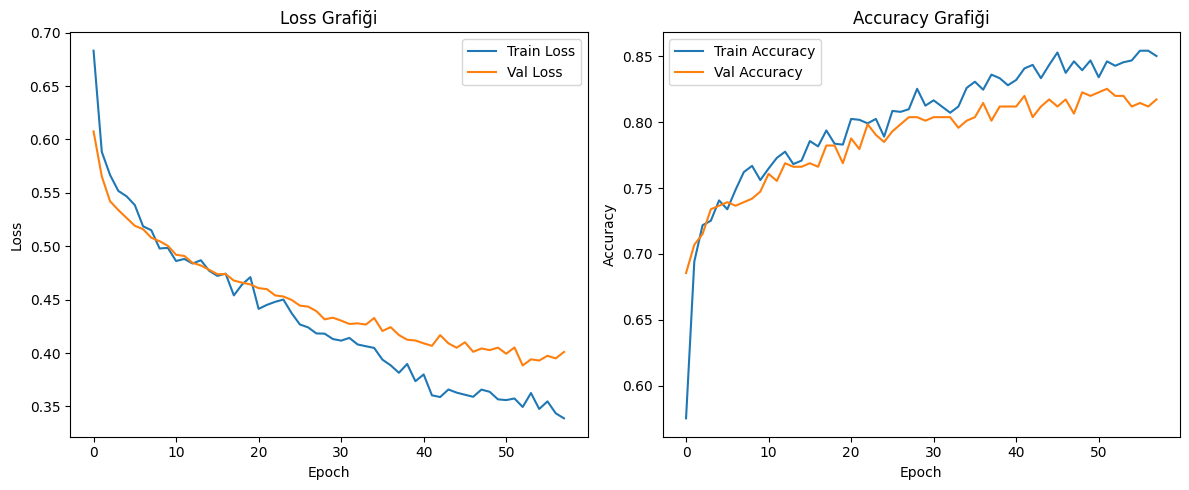

In [625]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Grafiği')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Grafiği')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

### 8. Building the ensemble model

In [626]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [627]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)

In [628]:
rf_probs = rf_model.predict_proba(X_test_scaled)[:, 1]

ann_probs = ann_model.predict(X_test_scaled).flatten()

cat_probs = cat_model.predict_proba(X_test)[:, 1]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


### 9. Weighting the probs and finding the optimal treshold for the prediction

In [629]:
ensemble_probs = 0.3 * ann_probs + 0.3 * rf_probs + 0.4 * cat_probs

# ensemble_probs = (ann_probs * 0.3 + rf_probs * 0.7)  

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, ensemble_probs)
optimal_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_index]

print("Optimal threshold :", optimal_threshold)

y_pred_ensemble = (ensemble_probs > optimal_threshold).astype(int)

Optimal threshold : 0.5541970901841694


### 10. Showing the results

              precision    recall  f1-score   support

           0       0.91      0.90      0.91       253
           1       0.88      0.90      0.89       213

    accuracy                           0.90       466
   macro avg       0.90      0.90      0.90       466
weighted avg       0.90      0.90      0.90       466



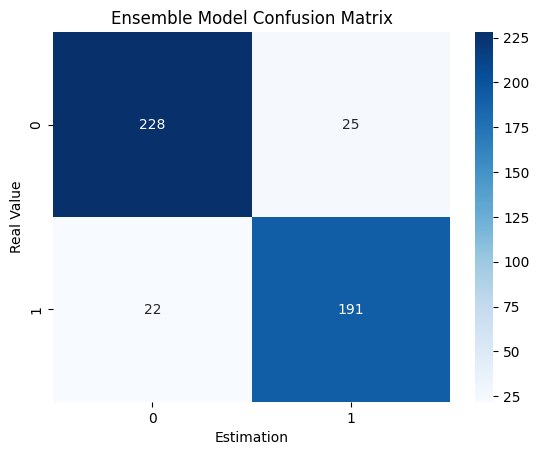

In [630]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(y_test, y_pred_ensemble))

cm = confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Ensemble Model Confusion Matrix")
plt.xlabel("Estimation")
plt.ylabel("Real Value")
plt.show()